In [1]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, roc_curve, auc
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
from sklearn.linear_model import QuantileRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor
import os
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import warnings
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
from sklearn.exceptions import ConvergenceWarning
from sklearn import preprocessing as skp
from sklearn import model_selection as sms
from sklearn import feature_selection as skf
from sklearn import linear_model as slm
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util as util
import nibabel as nib
import os
import pickle
from torch import nn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (15,5)
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0]//2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()
    

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index-1) % volume.shape[0] 
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index+1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [3]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
visualize = 1
# Load data
nrows = 256
ncols = 256
nslices = 160
segs = []
qsms = []
laros = []
voxel_sizes = []
trackers = []
q_directory = '/home/ali/RadDBS-QSM/data/nii/chh/orig/qsm/'
q_directory = os.listdir(q_directory)
q_directory = sorted(q_directory)
qu_directory = '/home/ali/RadDBS-QSM/data/nii/chh/lr_roi_ft'
qu_directory = os.listdir(qu_directory)
qu_directory = sorted(qu_directory)
s_directory = '/home/ali/RadDBS-QSM/data/nii/chh/orig/seg/'
s_directory = os.listdir(s_directory)
s_directory = sorted(s_directory)
m_directory = '/home/ali/RadDBS-QSM/data/nii/chh/masks'
m_directory = os.listdir(m_directory)
m_directory = sorted(m_directory)
case_list = []
d_count = 0
if visualize == 1:
    for filename in q_directory:
    
        seg_filename = s_directory[d_count]
        laro_filename = qu_directory[d_count]
        mask_filename = m_directory[d_count]
        seg = nib.load('/home/ali/RadDBS-QSM/data/nii/chh/orig/seg/'+seg_filename)
        mask = nib.load('/home/ali/RadDBS-QSM/data/nii/chh/masks/'+mask_filename)
        voxel_size = seg.header['pixdim'][0:3]
        voxel_sizes.append(voxel_size)
        segs.append(seg.get_fdata()[:nrows,:ncols,:nslices])
        qsm = nib.load('/home/ali/RadDBS-QSM/data/nii/chh/orig/qsm/'+filename)
        qsms.append(qsm.get_fdata()[:nrows,:ncols,:nslices])

        laro = nib.load('/home/ali/RadDBS-QSM/data/nii/chh/lr_roi_ft/'+laro_filename)
        laros.append(1000*laro.get_fdata()[:nrows,:ncols,:nslices])
        print('Appending arrays with segmentation',seg_filename,'QSM,',filename,
              'LARO,',laro_filename,'and mask',mask_filename)
        case_list.append(filename)
        n_cases = len(segs)
        d_count = d_count+1




Appending arrays with segmentation 01_roi_combined.nii QSM, 00001_qsm.nii.gz LARO, QSM_lrr_01.nii and mask mask01.nii
Appending arrays with segmentation 02_roi_combined.nii QSM, 00002_qsm.nii.gz LARO, QSM_lrr_02.nii and mask mask02.nii
Appending arrays with segmentation 03_roi_combined.nii QSM, 00003_qsm.nii.gz LARO, QSM_lrr_03.nii and mask mask03.nii
Appending arrays with segmentation 04_roi_combined.nii QSM, 00004_qsm.nii.gz LARO, QSM_lrr_04.nii and mask mask04.nii
Appending arrays with segmentation 05_roi_combined.nii QSM, 00005_qsm.nii.gz LARO, QSM_lrr_05.nii and mask mask05.nii
Appending arrays with segmentation 06_roi_combined.nii QSM, 00006_qsm.nii.gz LARO, QSM_lrr_06.nii and mask mask06.nii
Appending arrays with segmentation 07_roi_combined.nii QSM, 00007_qsm.nii.gz LARO, QSM_lrr_07.nii and mask mask07.nii
Appending arrays with segmentation 08_roi_combined.nii QSM, 00008_qsm.nii.gz LARO, QSM_lrr_08.nii and mask mask08.nii
Appending arrays with segmentation 09_roi_combined.nii Q

In [4]:
df = pd.read_csv('/home/ali/RadDBS-QSM/data/xlxs/updrs_iii_chh.csv')
df

,subjects,LCT,Unnamed: 2,UPDRSⅢ,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,NaN,NaN,NaN,Preoperative Off-Medicine,Preoperative On-Medicine,Postoperative Off-Medicine &Off-Stimulation\n,Postoperative Off-Medicine &On-Stimulation,Postoperative On-Medicine &On-Stimulation,NaN
1,1.0,62.26%,NaN,53,20,40,15,7,NaN
2,2.0,75.00%,NaN,32,8,26,17,10,NaN
3,3.0,51.72%,NaN,58,28,52,18,20,NaN
4,4.0,22.58%,NaN,62,48,61,36,28,NaN
5,5.0,55.88%,NaN,34,15,44,29,22,NaN
6,6.0,75.44%,NaN,57,14,55,32,16,NaN
7,7.0,84.00%,NaN,100,16,68,12,NaN,NaN
8,8.0,41.86%,NaN,43,25,48,26,26,NaN
9,9.0,72.58%,NaN,62,17,56,25,11,NaN


In [5]:
# Patient IDs
subject_id = np.asarray(df[df.columns[0]])[1:]

# Only extract ROI if it is present in all cases
seg_labels_all = segs[0]
case_number = np.zeros_like(np.asarray(s_directory))
for i in range(n_cases):
    case_number[i] = float(s_directory[i][:2])
subject_id_corr = subject_id[np.in1d(subject_id,case_number)]
for i in np.arange(n_cases):
    try:
        print('Found ROIs',str(np.unique(segs[i])),'at segmentation directory file',s_directory[i],'for case',str(subject_id_corr[i]))
    except:
        print('Case',subject_id[i],'quarantined')


Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 01_roi_combined.nii for case 1.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 02_roi_combined.nii for case 2.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 03_roi_combined.nii for case 3.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 04_roi_combined.nii for case 4.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 05_roi_combined.nii for case 5.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 06_roi_combined.nii for case 6.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 07_roi_combined.nii for case 7.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 08_roi_combined.nii for case 8.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 09_roi_combined.nii for case 9.0
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 10_roi_combined.nii for case 10.0
Found ROIs [0. 1. 2

In [6]:
pre_updrs_iii_off =  np.asarray(df[df.columns[3]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])                                
pre_updrs_iii_on =  np.asarray(df[df.columns[4]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])
post_updrs_iii_off =  np.asarray(df[df.columns[6]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])

per_change = (np.asarray(pre_updrs_iii_off).astype(float)-np.asarray(post_updrs_iii_off).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))
lct_change = (np.asarray(pre_updrs_iii_off).astype(float)-(np.asarray(pre_updrs_iii_on)).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))

In [7]:
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)

reextract = 0

# Assume all voxel sizes are identical
voxel_size = (0.9,0.9,0.9)
if reextract == 1:
    # Generate feature structure Phi from all ROIs and all cases
    extractor = featureextractor.RadiomicsFeatureExtractor()
    extractor.enableAllFeatures()
    extractor.enableAllImageTypes()
    extractor.enableFeatureClassByName('shape2D',enabled = False)

    seg_labels_all = np.unique(np.asarray(segs))
    Phi_gt = []
    Phi_vd = []
    Phi_lr = []
    seg_labels = []
    reextract = 0
    x_row_gt = []
    x_row_lr = []

    keylib = []
    roilib = []
    loop_count = 1
    n_rois = seg_labels_all[seg_labels_all>0].__len__()
    roi_names = np.asarray(['Background','Right substantia nigra','Right subthalamic nucleus',
                            'Left subthalamic nucleus', 'Left substantia nigra', 'Right dentate nucleus', 'Left dentate nucleus'])
    for i in np.arange(subject_id_corr.__len__()):
        seg_sitk = sitk.GetImageFromArray(segs[i])
        seg_sitk.SetSpacing(voxel_size)
        qsm_sitk_gt = sitk.GetImageFromArray(qsms[i])
        qsm_sitk_gt.SetSpacing(voxel_size)
        qsm_sitk_lr = sitk.GetImageFromArray(laros[i])
        qsm_sitk_lr.SetSpacing(voxel_size)
        # Index back since subject 12 is missing ROIs
        for j in seg_labels_all:
            if j>0:
                fv_count = 0
                featureVector_gt = extractor.execute(qsm_sitk_gt,seg_sitk,label=int(j));
                featureVector_lr = extractor.execute(qsm_sitk_lr,seg_sitk,label=int(j));
                Phi_gt.append(featureVector_gt)
                Phi_lr.append(featureVector_lr)
                for key, value in six.iteritems(featureVector_gt):
                    if 'diagnostic' in key:
                        next
                    else:
                        x_row_gt.append(featureVector_gt[key])
                        x_row_lr.append(featureVector_lr[key])
                        fv_count = fv_count+1
                        keylib.append(key)
                        roilib.append(roi_names[int(j)])
                x_row_gt.append(pre_updrs_iii_off[i])
                x_row_lr.append(pre_updrs_iii_off[i])
                fv_count = fv_count+1
        print('Extracting features for subject',subject_id_corr[i],'and appending feature matrix with vector of length',fv_count,'with UPDRS score',pre_updrs_iii_off[i])
                
    X0_gt = np.array(x_row_gt)
    X0_lr = np.array(x_row_lr)
    np.save('/home/ali/RadDBS-QSM/data/npy/rp/X0_gt_chh_rois_rp.npy',X0_gt)
    np.save('/home/ali/RadDBS-QSM/data/npy/rp/X0_lr_chh_rois_rp.npy',X0_lr)

    K = np.asarray(keylib)
    R = np.asarray(roi_names)
    np.save('/home/ali/RadDBS-QSM/data/npy/rp/K_chh_rp.npy',K)
    np.save('/home/ali/RadDBS-QSM/data/npy/rp/R_chh_rp.npy',R)

    print('Saving ground truth feature vector')
    with open('/home/ali/RadDBS-QSM/data/npy/rp/Phi_mcl_gt_roi_chh_rp', 'wb') as fp:  
        pickle.dump(Phi_gt, fp)
    
    print('Saving undersampled feature vector')
    with open('/home/ali/RadDBS-QSM/data/npy/rp/Phi_mcl_lr_roi_chh_rp', 'wb') as fp:  
        pickle.dump(Phi_lr, fp)

else:
    X0_gt = np.load('/home/ali/RadDBS-QSM/data/npy/rp/X0_gt_chh_rois_rp.npy')
    X0_lr = np.load('/home/ali/RadDBS-QSM/data/npy/rp/X0_lr_chh_rois_rp.npy')
    K = np.load('/home/ali/RadDBS-QSM/data/npy/rp/K_chh_rp.npy')
    R = np.load('/home/ali/RadDBS-QSM/data/npy/rp/R_chh_rp.npy')
    n_rois = R.shape[0]-1
    with open('/home/ali/RadDBS-QSM/data/npy/rp/Phi_mcl_gt_roi_chh_rp', "rb") as fp:  
        Phi_gt = pickle.load(fp)
    
    with open('/home/ali/RadDBS-QSM/data/npy/rp/Phi_mcl_lr_roi_chh_rp', "rb") as fp:  
        Phi_lr = pickle.load(fp)

    

In [8]:
n_features = 1596
n_rois = 6
X_all_c = X0_gt.reshape(n_cases,n_rois,n_features)[:,0:4,:]
K_all_c = K.reshape(n_cases,n_rois,n_features-1)[:,0:4,:]
K_all_c = K_all_c[0,:,:].reshape(-1,1)

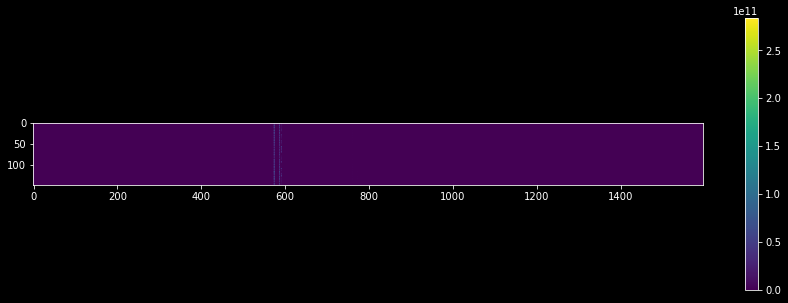

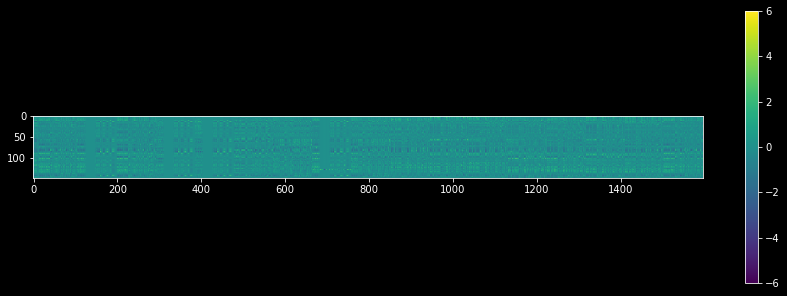

: 

In [24]:
plt.imshow((X_all_c.reshape(-1,1596).astype(float)),cmap='viridis')
plt.colorbar()
plt.show()
X = skp.StandardScaler().fit_transform(X_all_c.reshape(X_all_c.shape[0],-1))
plt.imshow((X.reshape(-1,1596).astype(float)),cmap='viridis')
plt.colorbar()
plt.show()

In [15]:
np.mean(X_all_c.astype(float))

142257107.86951497

In [9]:
n_cases = len(per_change)
n_roisc = Phi_gt.__len__()/n_cases
L = int(len(X0_gt)/n_cases)
n_features = int(L/n_rois)
subsc = subject_id_corr
pre_updrs_off = pre_updrs_iii_off
results_ls_aug = np.zeros_like(per_change)

results_lgr_aug = np.zeros_like(per_change)
results_lgrp_aug = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
results_lgr = np.zeros_like(per_change)
results_lgrp = np.zeros_like(per_change)
r = 1

In [10]:
retrain = 1
if retrain == 1:

  Js = []
  aug = True
  err_var = np.zeros_like(per_change)
  rerror = np.zeros_like(per_change)
  kappa = []
  K_nz = []
  E_nz = []
  c = 0

  K_all_c = np.append(K_all_c,['pre updrs']*5)
  for j in np.arange(len(subsc)):
      test_id = subsc[j]
      test_index = subsc == test_id
      train_index = subsc != test_id
      X_train = X_all_c[train_index,:,:]
      X_test = X_all_c[test_index,:,:]
      y_train = per_change[train_index]
      y_test = per_change[test_index]

      y_cat = y_train <= 0.3
      idy = np.where(y_cat==1)
      # Cross validation
                                            
      X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                  X_train,train_index,X_test,
                                                  test_index,pre_updrs_off,None,None,None,None,None,None,None,None,None,False,False,False)
      cvn = 5
      cv_scores = np.zeros((cvn,1))
      cv_lgr_scores = np.zeros((cvn,1))
      rs = 1
      rcfs = 1000
      (mu, sigma) = stats.norm.fit(y_train)
      kappa = stats.skew(y_train)
      print('Label distribution of:',mu,sigma,kappa)
      for jj in np.arange(2,cvn):
        # Resample to avoid stratification errors
        while np.sum(y_cat) < cvn:
          np.random.seed(rs)
          idyr = np.random.choice(np.asarray(idy).ravel())
          X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
          y_train = np.append(y_train,y_train[idyr])
          y_cat = y_train <= 0.3
          rs = rs+1
          print('Resampled to size',y_train.shape)
        if aug == True:
          y_train_n = y_train+(1.96*sigma)*np.random.normal(0,1,1)
          y_train = np.hstack((y_train,y_train_n))
          y_cat = y_train <= 0.3
          X0_ss0 = np.vstack((X0_ss0,X0_ss0))
      
      for jj in np.arange(2,cvn):
        skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
        skf_gen = skf_g.split(X0_ss0,y_cat)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None)
        with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
          # Feature selection
          warnings.filterwarnings("ignore", category=ConvergenceWarning)
          sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen,n_jobs=1)
          # Stratifies classifiers automatically
          sel_lr = skf.RFECV(lgr,step=rcfs,cv=jj,n_jobs=1)
          X0_ss = sel.fit_transform(X0_ss0,y_train)
          X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
          est_ls = lasso.fit(X0_ss,y_train)
          est_lgr = lgr.fit(X0_ssl,y_cat)
          cv_scores[jj] = est_ls.score(X0_ss,y_train)
          cv_lgr_scores[jj] = est_lgr.score(X0_ssl,y_cat)
          print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
          
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
        best_cv = np.argmax(cv_scores)
        best_cv_lgr = np.argmax(cv_lgr_scores)

        # Break any ties
        if np.sum(cv_scores == best_cv) > 1:
          cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
          cv_lgr_scores_tb = np.zeros((np.sum(cv_scores == best_cv_lgr),1))
          for jjj in (cv_scores == cv_scores[best_cv]):
            if jjj > 0:
              print('Breaking tie')
              skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
              skf_gen = skf_g.split(X0_ss0,y_cat) 
              X0_ss = sel.fit_transform(X0_ss0,y_train)
              X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
              est_ls = lasso.fit(X0_ss,y_train)
              est_lgr = lgr.fit(X0_ssl,y_cat)
              lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
              lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None)
              est_ls = lasso.fit(X0_ss,y_train)
              est_lgr = lgr.fit(X0_ssl,y_cat)
              cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
              cv_lgr_scores_tb[jj] = est_lgr.score(sel_lr.fit_transform(X0_ss0,y_cat),y_cat)
          best_cv = np.argmax(cv_scores_tb)
          best_cv_lgr = np.argmax(cv_lgr_scores_tb)
        
        # Fit whole dataset with optimal cv
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None)
        sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
        sel_lr = skf.RFECV(lgr,step=rcfs,cv=best_cv)
        X0_ss = sel.fit_transform(X0_ss0,y_train)
        X_test_ss = sel.transform(X_test_ss0)
        X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
        X_test_ssl = sel_lr.transform(X_test_ss0)
        K_ss = sel.transform(K_all_c.reshape(1,-1))

      # LASSO
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=best_cv,class_weight=None)
        est_ls = lasso.fit(X0_ss,y_train)
        est_lgr = lgr.fit(X0_ssl,y_cat)
      results_lgr_aug[c] = est_lgr.predict(X_test_ssl)
      results_lgrp_aug[c] = est_lgr.predict_proba(X_test_ssl)[0][0]
      results_ls_aug[c] = est_ls.predict(X_test_ss)
      print('Lasso predicts',str(np.round(results_ls_aug[c],4)),'and logistic regression predicts',results_lgr_aug[c],
                'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv,'and',sum(y_cat),'minority cases')
      K_nz.append(np.squeeze(K_ss)[est_ls.coef_>0])
      E_nz.append(est_ls.coef_[est_ls.coef_>0])
      c=c+1

  # np.save('results_ls_aug_d.npy',results_ls_aug)
  # np.save('results_lgr_aug_d.npy',results_lgr_aug)
  np.save('results_lgrp_aug_d.npy',results_lgrp_aug)

else:
  results_ls_aug = np.load('results_ls_aug_d.npy')
  results_lgr_aug = np.load('results_lgr_aug_d.npy')
  #results_lgrp_aug = np.load('results_lgr_aug_d.npy')

  


Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.49930282] from dataset of size (304, 1385)
LassoCV score for 3 is [0.49100545] from dataset of size (304, 1385)
LassoCV score for 4 is [0.49930282] from dataset of size (304, 385)
Lasso predicts 0.6384 and logistic regression predicts 0.0 for case with 0.72 and selected CV 2 and 82 minority cases
Label distribution of: 0.5738548357091768 0.20932917254901903 -0.3279210191356042
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.50045498] from dataset of size (304, 6385)
LassoCV score for 3 is [0.49602442] from dataset of size (304, 2385)
LassoCV score for 4 is [0.50045498] from dataset of size (304, 2385)
Lasso predicts 0.4416 and logistic regression predicts 0.0 for case with 0.47 and selected CV 4 and 80 minority cases
Label distribution of: 0.5677185809199048 0.20908232478622193 -0.24926099868801613
Resampl

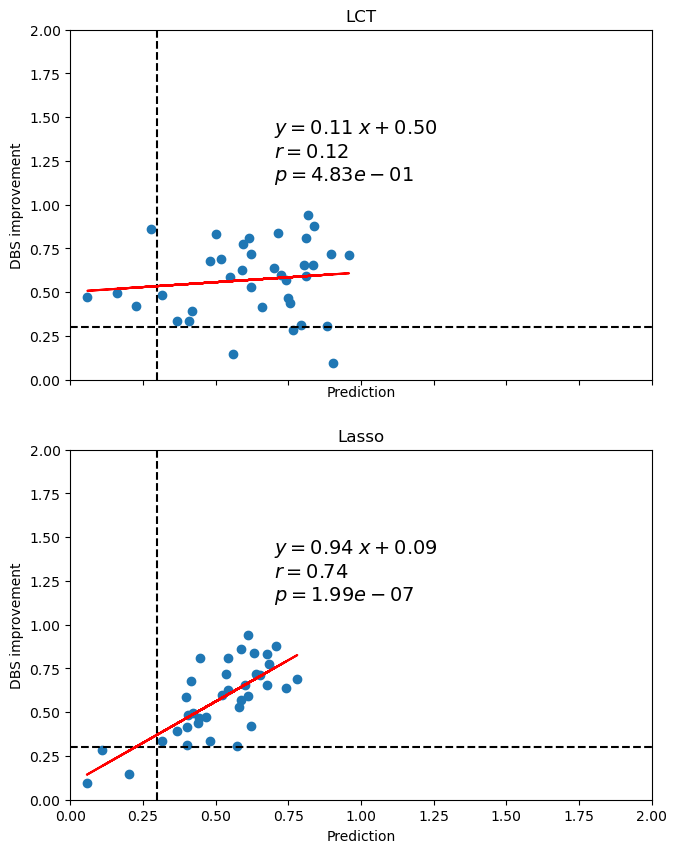

In [15]:
pre_imp = (np.asarray(pre_updrs_iii_off,dtype=float)-np.asarray(pre_updrs_iii_on,dtype=float))/np.asarray(pre_updrs_iii_off,dtype=float)
util.eval_prediction(np.vstack((pre_imp,
                               results_ls_aug,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                ],(15,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')

In [165]:
fig_size = (15,5)
results = np.vstack((pre_imp,results_ls_aug))
y_test = per_change
names = ['LCT','Noise compensated Lasso']
                       

<function matplotlib.pyplot.show(*args, **kw)>

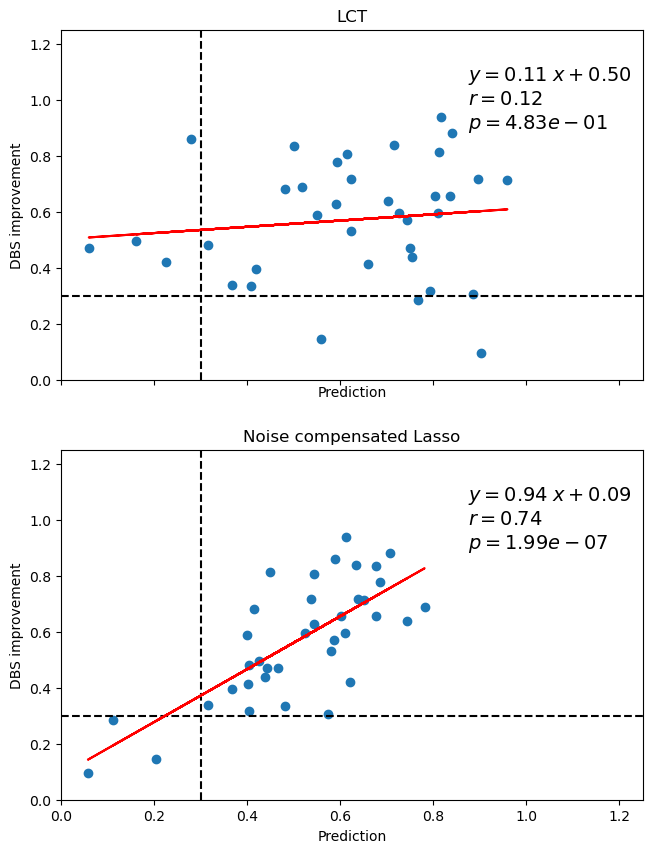

In [166]:
    plt.rcParams["figure.figsize"] = fig_size
    n_models = results.shape[0]
    # Cross validation results
    if np.mod(n_models,2)==0:
        plt.rcParams["figure.figsize"] = (fig_size[0]/2,fig_size[1]*2)
        [fig,ax] = plt.subplots(2,int(n_models//2),sharex=True, sharey=True)
        ax = np.ravel(ax)
        ax_reshape = 2
    elif np.mod(n_models,3)==0:
        plt.rcParams["figure.figsize"] = (fig_size[0]/3,fig_size[1]*3)
        [fig,ax] = plt.subplots(3,int(n_models//3),sharex=True, sharey=True)
        ax = np.ravel(ax)
        ax_reshape = 3
    else:
        [fig,ax] = plt.subplots(1,n_models,sharex=True, sharey=True)
        ax_reshape = 0
    for j in np.arange(n_models):
        lr_prepost = linregress(results[j],y_test)
        ax[j].scatter(results[j],y_test)
        ax[j].plot(results[j],results[j]*lr_prepost.slope+lr_prepost.intercept,'-r')
        ax[j].set_title(names[j])
        ax[j].set_ylabel("DBS improvement")
        ax[j].set_xlabel("Prediction")
        text = f"$y={lr_prepost.slope:0.2f}\; x{lr_prepost.intercept:+0.2f}$\n$r = {lr_prepost.rvalue:0.2f}$\n$p = {lr_prepost.pvalue:0.2e}$"
        ax[j].text(0.7, 0.9, text,transform=ax[j].transAxes,
            fontsize=14, verticalalignment='top')
        ax[j].hlines(0.3,0,2,linestyle='dashed',color='black')
        ax[j].vlines(0.3,0,2,linestyle='dashed',color='black')
    if ax_reshape == 3:
        ax = np.reshape(ax, (3, int(n_models/3)))
    elif ax_reshape == 2:
        ax = np.reshape(ax, (2, int(n_models/2)))
    plt.style.use('default')
    plt.ylim([0,1.25])
    plt.xlim([0,1.25])
    plt.show

In [196]:
z_train = (y_train-np.mean(y_train))/(np.std(y_train)/np.sqrt(len(y_train)))

In [197]:
z_train

array([  5.56278102,  -1.50685434,   4.78453629,  -2.91363107,
       -10.66863554,  -2.36562782,  10.20556673,  -3.59732322,
         2.13928125,   8.28316327,   3.32187775,   5.54674044,
        -6.09378567,   4.50955648,  -5.22981879,   1.89609296,
        11.87949627,   8.97336859, -12.10074437,  -3.04807663,
         1.41743663,   3.81856507,   3.03443588,  -1.45450131,
        -6.78753051,   2.08694959,   0.22079582,   9.64921224,
        -1.1442611 ,   3.81856507,  -5.36352795,  -0.7699713 ,
         7.2942726 ,   8.12702264,   5.48601538,  -5.87947091,
       -12.10074437, -10.66863554,  -6.78753051,  -6.78753051,
        -6.78753051])

In [44]:
Js = []
aug = False
err_var = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
kappa = []
K_nz = []
E_nz = []
c = 0

K_all_c = np.append(K_all_c,['pre updrs']*5)
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]

    y_cat = y_train <= 0.3
    idy = np.where(y_cat==1)
    # Cross validation
                                          
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,
                                                test_index,pre_updrs_off,None,None,None,None,None,None,None,None,None,False,False,False)
    cvn = 5
    cv_scores = np.zeros((cvn,1))
    cv_lgr_scores = np.zeros((cvn,1))
    rs = 1
    rcfs = 1000
    (mu, sigma) = stats.norm.fit(y_train)
    kappa = stats.skew(y_train)
    print('Label distribution of:',mu,sigma,kappa)
    for jj in np.arange(2,cvn):
      # Resample to avoid stratification errors
      while np.sum(y_cat) < 2*(cvn-1):
        np.random.seed(rs)
        idyr = np.random.choice(np.asarray(idy).ravel())
        X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
        y_train = np.append(y_train,y_train[idyr])
        y_cat = y_train <= 0.3
        rs = rs+1
        print('Resampled to size',y_train.shape)
      if aug == True:
        y_train_n = y_train+(1.96*sigma)*np.random.normal(0,1,1)
        y_train = np.hstack((y_train,y_train_n))
        y_cat = y_train <= 0.3
        X0_ss0 = np.vstack((X0_ss0,X0_ss0))
    
    for jj in np.arange(2,cvn):
      skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
      skf_gen = skf_g.split(X0_ss0,y_cat)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
      lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight='balanced')
      print('Found minority samples:',sum(y_cat))
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
        # Feature selection
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen,n_jobs=1)
        # Stratifies classifiers automatically
        with warnings.catch_warnings():
          warnings.filterwarnings("ignore", category=UserWarning)
          sel_lr = skf.RFECV(lgr,step=rcfs,cv=jj,n_jobs=1)
        X0_ss = sel.fit_transform(X0_ss0,y_train)
        X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
        est_ls = lasso.fit(X0_ss,y_train)
        est_lgr = lgr.fit(X0_ssl,y_cat)
        cv_scores[jj] = est_ls.score(X0_ss,y_train)
        cv_lgr_scores[jj] = est_lgr.score(X0_ssl,y_cat)
        print('LogisticRegressionCV score for',jj,'is',cv_lgr_scores[jj],'from dataset of size',X0_ss.shape)
        
    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
      best_cv = np.argmax(cv_scores)
      best_cv_lgr = np.argmax(cv_lgr_scores)

      # Break any ties
      if np.sum(cv_scores == best_cv) > 1:
        cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
        cv_lgr_scores_tb = np.zeros((np.sum(cv_scores == best_cv_lgr),1))
        for jjj in (cv_scores == cv_scores[best_cv]):
          if jjj > 0:
            print('Breaking tie')
            skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
            skf_gen = skf_g.split(X0_ss0,y_cat) 
            X0_ss = sel.fit_transform(X0_ss0,y_train)
            X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
            est_ls = lasso.fit(X0_ss,y_train)
            est_lgr = lgr.fit(X0_ssl,y_cat)
            lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
            lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight='balanced')
            est_ls = lasso.fit(X0_ss,y_train)
            est_lgr = lgr.fit(X0_ssl,y_cat)
            cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
            cv_lgr_scores_tb[jj] = est_lgr.score(sel_lr.fit_transform(X0_ss0,y_cat),y_cat)
        best_cv = np.argmax(cv_scores_tb)
        best_cv_lgr = np.argmax(cv_lgr_scores_tb)
      
      # Fit whole dataset with optimal cv
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
      lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight='balanced')
      sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
      sel_lr = skf.RFECV(lgr,step=rcfs,cv=best_cv)
      X0_ss = sel.fit_transform(X0_ss0,y_train)
      X_test_ss = sel.transform(X_test_ss0)
      X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
      X_test_ssl = sel_lr.transform(X_test_ss0)
      K_ss = sel.transform(K_all_c.reshape(1,-1))

    # LASSO
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
      lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=best_cv,class_weight='balanced')
      est_ls = lasso.fit(X0_ss,y_train)
      est_lgr = lgr.fit(X0_ssl,y_cat)
    results_lgr[c] = est_lgr.predict(X_test_ssl)
    results_lgrp[c] = est_lgr.predict_proba(X_test_ssl)[0][0]
    results_ls[c] = est_ls.predict(X_test_ss)
    print('Lasso predicts',str(np.round(results_ls[c],4)),'and logistic regression predicts',results_lgr[c],
              'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv,'and',sum(y_cat),'minority cases')
    K_nz.append(np.squeeze(K_ss)[est_ls.coef_>0])
    E_nz.append(est_ls.coef_[est_ls.coef_>0])
    c=c+1

      

  


Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
Resampled to size (37,)
Resampled to size (38,)
Resampled to size (39,)
Resampled to size (40,)
Resampled to size (41,)
Found minority samples: 8
LogisticRegressionCV score for 2 is [0.97560976] from dataset of size (41, 385)
Found minority samples: 8
LogisticRegressionCV score for 3 is [0.97560976] from dataset of size (41, 2385)
Found minority samples: 8
LogisticRegressionCV score for 4 is [1.] from dataset of size (41, 4385)
Lasso predicts 0.7457 and logistic regression predicts 0.0 for case with 0.72 and selected CV 4 and 8 minority cases
Label distribution of: 0.5738548357091768 0.20932917254901903 -0.3279210191356042
Resampled to size (37,)
Resampled to size (38,)
Resampled to size (39,)
Resampled to size (40,)
Resampled to size (41,)
Found minority samples: 8
LogisticRegressionCV score for 2 is [1.] from dataset of size (41, 5385)
Found minority samples: 8
LogisticRegressionCV score for 3 is [0.97

Define probability of an unsucessful procedure as $P = 1-u$ where $u$ is the UPDRS percent improvement prediction between $0$ and $1$.

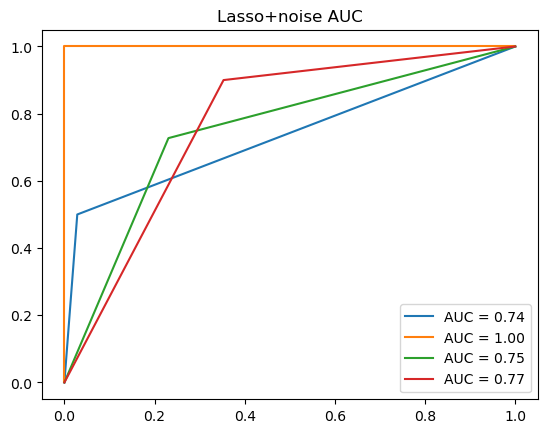

In [60]:
t = [0.15,0.3,0.45,0.6]
for j in np.arange(len(t)):
    y_bin = per_change<t[j]
    y_predicted = results_ls_aug < t[j]#1-results_ls_aug
    fpr, tpr, _ = roc_curve(y_bin,  y_predicted)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.title('Lasso+noise AUC')
plt.legend()
plt.show()

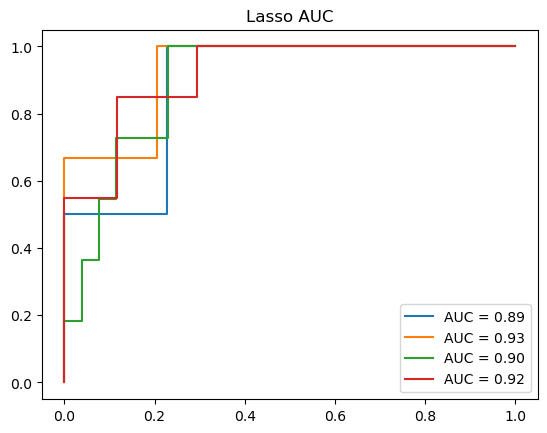

In [146]:
t = [0.15,0.3,0.45,0.6]
for j in np.arange(len(t)):
    y_bin = per_change<t[j]
    y_predicted = 1-results_ls
    fpr, tpr, _ = roc_curve(y_bin,  y_predicted)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.title('Lasso AUC')
plt.legend()
plt.show()

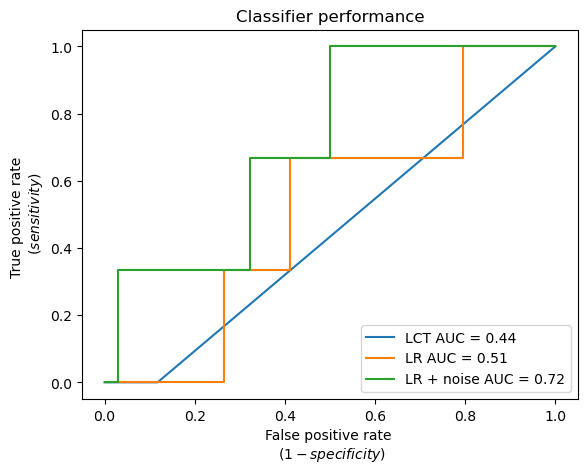

In [152]:
t = 0.3
y_bin = per_change<t

y_predicted_ls = 1-results_ls
y_predicted_ls_aug = 1-results_ls_aug
y_predicted_lct = pre_imp < 0.3
y_predicted_aug = 1-results_lgrp_aug
y_predicted_lr = 1-results_lgrp

fprlsa, tprlsa, _ = roc_curve(y_bin,  y_predicted_ls_aug)
fprls, tprls, _ = roc_curve(y_bin,  y_predicted_ls)
fprl, tprl, _ = roc_curve(y_bin,  y_predicted_lct)
fpra, tpra, _ = roc_curve(y_bin, y_predicted_aug)
fprlr, tprlr, _ = roc_curve(y_bin, y_predicted_lr)

roc_auc_lct = auc(fprl, tprl)
roc_auc_lr = auc(fprlr, tprlr)
roc_auc_lr_aug = auc(fpra, tpra)
roc_auc_ls = auc(fprls, tprls)
roc_auc_ls_aug = auc(fprlsa, tprlsa)
plt.rcParams['legend.loc']='lower right'
plt.plot(fprl, tprl, label = 'LCT AUC = %0.2f' % roc_auc_lct)
plt.plot(fprlr, tprlr, label = 'LR AUC = %0.2f' % roc_auc_lr)
plt.plot(fpra, tpra, label = 'LR + noise AUC = %0.2f' % roc_auc_lr_aug)
# plt.plot(fprls, tprls, label = 'LASSO AUC = %0.2f' % roc_auc_ls)
# plt.plot(fprlsa, tprlsa, label = 'LASSO + noise AUC = %0.2f' % roc_auc_ls_aug)
plt.title('Classifier performance')
plt.xlabel('False positive rate \n $(1-specificity$)')
plt.ylabel('True positive rate \n $(sensitivity$)')
plt.legend()
plt.show()

In [153]:
# t = [0.15,0.3,0.45,0.6]
# for j in np.arange(len(t)):
#     y_bin = per_change<t[j]
#     y_predicted = 1-results_lgrp
#     fpr, tpr, _ = roc_curve(y_bin,  y_predicted)
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
# plt.title('Logistic regression AUC')
# plt.legend()
# plt.show()

In [154]:
# t = [0.15,0.3,0.45,0.6]
# for j in np.arange(len(t)):
#     y_bin = per_change<t[j]
#     y_predicted = pre_imp<t[j]
#     fpr, tpr, _ = roc_curve(y_bin,  y_predicted)
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
# plt.title('LCT AUC')
# plt.legend()
# plt.show()

In [155]:
acc_ls_aug = util.classification_accuracy((results_ls_aug < 0.3).astype(int),(per_change < 0.3).astype(int))
sns_ls_aug = util.classification_sensitivity((results_ls_aug < 0.3).astype(int),(per_change < 0.3).astype(int))
spf_ls_aug = util.classification_specificity((results_ls_aug < 0.3).astype(int),(per_change < 0.3).astype(int))
auc_ls_aug = roc_auc_ls_aug

In [191]:
acc_ls = util.classification_accuracy((results_ls < 0.3).astype(int),(per_change < 0.3).astype(int))
sns_ls = util.classification_sensitivity((results_ls < 0.3).astype(int),(per_change < 0.3).astype(int))
spf_ls = util.classification_specificity((results_ls < 0.3).astype(int),(per_change < 0.3).astype(int))
auc_ls = roc_auc_ls

In [157]:
acc_lgr = util.classification_accuracy((results_lgr).astype(int),(per_change < 0.3).astype(int))
sns_lgr = util.classification_sensitivity((results_lgr).astype(int),(per_change < 0.3).astype(int))
spf_lgr = util.classification_specificity((results_lgr).astype(int),(per_change < 0.3).astype(int))
auc_lgr = roc_auc_lr

In [158]:
acc_lgr_aug = util.classification_accuracy((results_lgr_aug).astype(int),(per_change < 0.3).astype(int))
sns_lgr_aug = util.classification_sensitivity((results_lgr_aug).astype(int),(per_change < 0.3).astype(int))
spf_lgr_aug = util.classification_specificity((results_lgr_aug).astype(int),(per_change < 0.3).astype(int))
auc_lgr_aug = roc_auc_lr_aug

In [159]:
acc_lct = util.classification_accuracy((pre_imp < 0.3).astype(int),(per_change < 0.3).astype(int))
sns_lct = util.classification_sensitivity((pre_imp < 0.3).astype(int),(per_change < 0.3).astype(int))
spf_lct = util.classification_specificity((pre_imp < 0.3).astype(int),(per_change < 0.3).astype(int))
auc_lct = roc_auc_lct

In [189]:
c = ['Levodopa challenge','Logistic regression','Logistic regression + noise','Lasso','Lasso + noise']
d = {'accuracy': [acc_lct,acc_lgr,acc_lgr_aug,acc_ls,acc_ls_aug], 'sensitivity': [sns_lct,sns_lgr,sns_lgr_aug,sns_ls,sns_ls_aug], 'specificity': [spf_lct,spf_lgr,spf_lgr_aug,spf_ls,spf_ls_aug], 'auc': [auc_lct,auc_lgr,auc_lgr_aug,'-','-']}
df = pd.DataFrame(index=c,data=d)


In [190]:
df

,accuracy,sensitivity,specificity,auc
Levodopa challenge,0.810811,1.0,0.882353,0.441176
Logistic regression,0.891892,1.0,0.970588,0.509804
Logistic regression + noise,0.891892,1.0,0.942857,0.715686
Lasso,0.918919,1.0,1.000000,-
Lasso + noise,1.000000,1.0,1.000000,-


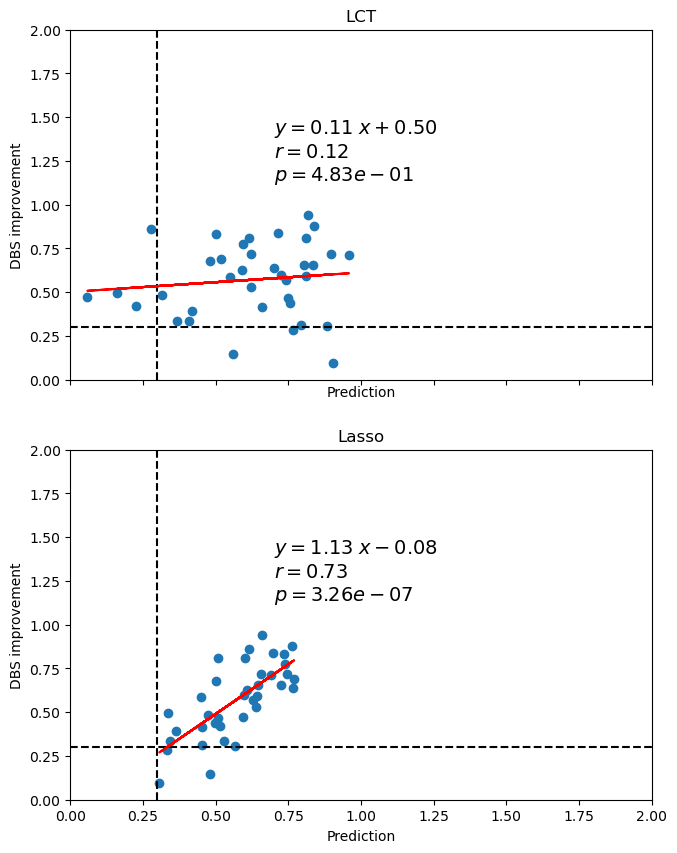

In [162]:
pre_imp = (np.asarray(pre_updrs_iii_off,dtype=float)-np.asarray(pre_updrs_iii_on,dtype=float))/np.asarray(pre_updrs_iii_off,dtype=float)
util.eval_prediction(np.vstack((pre_imp,
                               results_ls,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                ],(15,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')

In [167]:
fig_size = (15,5)
results = np.vstack((pre_imp,results_ls))
y_test = per_change
names = ['LCT','Lasso']
                       

(0.0, 1.25)

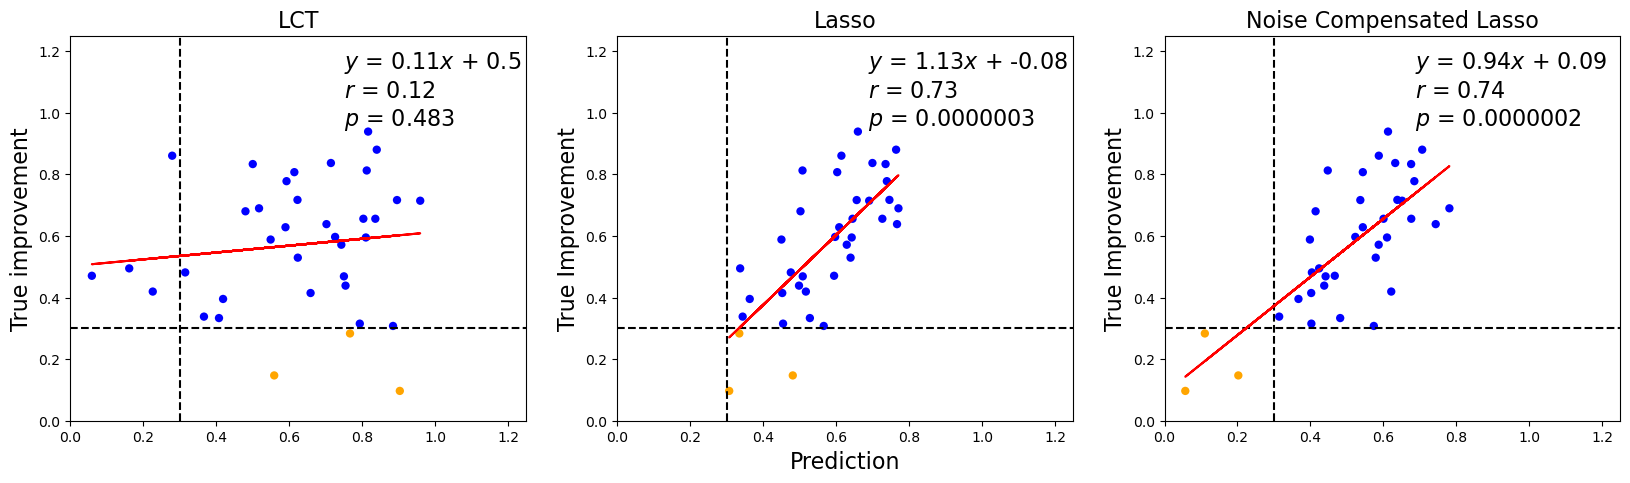

In [183]:
pre_imp = np.repeat((np.asarray(pre_updrs_iii_off,dtype=float)-np.asarray(pre_updrs_iii_on,dtype=float))/np.asarray(pre_updrs_iii_off,dtype=float),r)
per_change = np.repeat(per_change,r)
plt.rcParams['figure.figsize'] = [20, 5]
fig,ax = plt.subplots(1,3,sharex=True,sharey=True)
#ax[0].scatter(pre_imp,per_change)
col = np.where(per_change <= 0.3,'orange','blue')
ax[0].scatter(pre_imp,per_change, c=col,linewidth=0)
lr = stats.linregress(pre_imp,per_change)
y_model = pre_imp*lr.slope+lr.intercept
ax[0].plot(pre_imp,y_model,color='r')
ax[0].text(0.6,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.3f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[0].transAxes,fontsize=16)  
ax[0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].set_title('LCT',fontsize=16)
ax[0].set_ylabel('True improvement',fontsize=16)

col = np.where(per_change <= 0.3,'orange','blue')
ax[1].scatter(results_ls,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls),per_change)
y_model = results_ls*lr.slope+lr.intercept
ax[1].plot(results_ls,y_model,color='r')
ax[1].text(0.55,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[1].transAxes,fontsize=16) 
ax[1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].set_title('Lasso',fontsize=16)
ax[1].set_xlabel('Prediction',fontsize=16)
ax[1].set_ylabel('True Improvement',fontsize=16)
ax[1].yaxis.set_tick_params(labelleft=True)
col = np.where(per_change <= 0.3,'orange','blue')
ax[2].scatter(results_ls_aug,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls_aug),per_change)
y_model = results_ls_aug*lr.slope+lr.intercept
ax[2].plot(results_ls_aug,y_model,color='r')
ax[2].text(0.55,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
                    ha='left', va='bottom', transform=ax[2].transAxes,fontsize=16) 
ax[2].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[2].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[2].set_ylabel('True Improvement',fontsize=16)
ax[2].yaxis.set_tick_params(labelleft=True)
ax[2].set_title('Noise Compensated Lasso',fontsize=16)
plt.ylim([0,1.25])
plt.xlim([0,1.25])



In [310]:
def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1-data2                   # Difference between datasets
    md        = np.mean(diff)                 # Mean of the difference
    sd        = np.std(diff, axis=0)          # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.text(0.1, 2*md, r'$\mu$ = '+str(np.round(md,2)), horizontalalignment='center',verticalalignment='center')
    plt.text(0.5, 0.4, r'$\mu + 1.96 \sigma$ = '+str(np.round(md + 1.96*sd,2)), horizontalalignment='center',verticalalignment='center')
    plt.text(0.5, -0.5, r'$\mu - 1.96 \sigma$ = '+str(np.round(md - 1.96*sd,2)), horizontalalignment='center',verticalalignment='center')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    plt.ylim([-4*1.96*sd,4*1.96*sd])
    diff_in = np.logical_and(diff < md + 1.96*sd,diff > md - 1.96*sd)
    plt.scatter(mean[diff_in], diff[diff_in], *args, **kwargs)
    # print(sum(diff_in))
    # print(len(diff))
    # print('Number of features outside limits of agreement:',len(diff)-sum(diff_in),'of',len(diff),'evaluated features')
    # print('Limits of agreement are:',str(md-1.96*sd),str(md+1.96*sd))
    # print('Fraction of features within limits of agreement: ',str(sum(diff_in)/len(diff.ravel())))
    plt.xlabel(r'$\frac{y_{true}+y_{predicted}}{2}$',fontsize=16)
    plt.ylabel(r'$y_{predicted}-y_{true}$',fontsize=12)
    return diff,diff_in

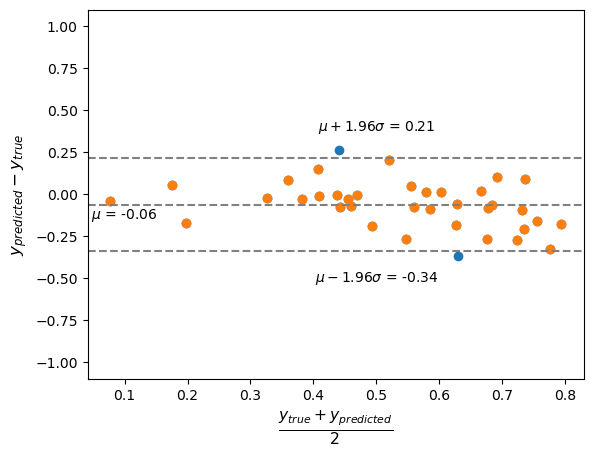

: 

In [311]:
d,din = bland_altman_plot(results_ls_aug,per_change)

(0.0, 1.0)

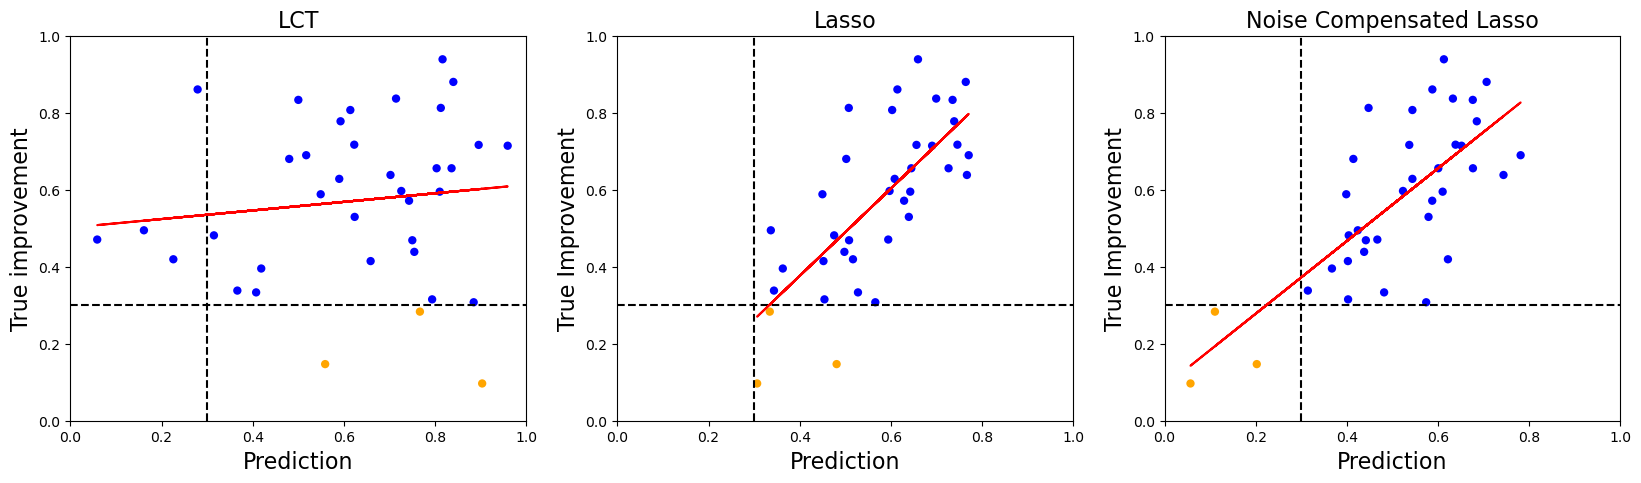

In [187]:
pre_imp = np.repeat((np.asarray(pre_updrs_iii_off,dtype=float)-np.asarray(pre_updrs_iii_on,dtype=float))/np.asarray(pre_updrs_iii_off,dtype=float),r)
per_change = np.repeat(per_change,r)
plt.rcParams['figure.figsize'] = [20, 5]
fig,ax = plt.subplots(1,3,sharex=True,sharey=True)
#ax[0].scatter(pre_imp,per_change)
col = np.where(per_change <= 0.3,'orange','blue')
ax[0].scatter(pre_imp,per_change, c=col,linewidth=0)
lr = stats.linregress(pre_imp,per_change)
y_model = pre_imp*lr.slope+lr.intercept
ax[0].plot(pre_imp,y_model,color='r')
# ax[0].text(0.6,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.3f}'.format(lr.pvalue))),
#                     ha='left', va='bottom', transform=ax[0].transAxes,fontsize=16)  
ax[0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].set_title('LCT',fontsize=16)
ax[0].set_xlabel('Prediction',fontsize=16)
ax[0].set_ylabel('True improvement',fontsize=16)
col = np.where(per_change <= 0.3,'orange','blue')
ax[1].scatter(results_ls,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls),per_change)
y_model = results_ls*lr.slope+lr.intercept
ax[1].plot(results_ls,y_model,color='r')
# ax[1].text(0.55,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
#                     ha='left', va='bottom', transform=ax[1].transAxes,fontsize=16) 
ax[1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].set_title('Lasso',fontsize=16)
ax[1].set_xlabel('Prediction',fontsize=16)
ax[1].set_ylabel('True Improvement',fontsize=16)
ax[1].yaxis.set_tick_params(labelleft=True)
col = np.where(per_change <= 0.3,'orange','blue')
ax[2].scatter(results_ls_aug,per_change, c=col,linewidth=0)
lr = stats.linregress(np.squeeze(results_ls_aug),per_change)
y_model = results_ls_aug*lr.slope+lr.intercept
ax[2].plot(results_ls_aug,y_model,color='r')
# ax[2].text(0.55,0.75,'$y$ = '+str(np.round(lr.slope,2))+'$x$ + '+str(np.round(lr.intercept,2))+'\n'+'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(('{:.7f}'.format(lr.pvalue))),
#                     ha='left', va='bottom', transform=ax[2].transAxes,fontsize=16) 
ax[2].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[2].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[2].set_xlabel('Prediction',fontsize=16)
ax[2].set_ylabel('True Improvement',fontsize=16)
ax[2].yaxis.set_tick_params(labelleft=True)
ax[2].set_title('Noise Compensated Lasso',fontsize=16)
plt.ylim([0,1])
plt.xlim([0,1])



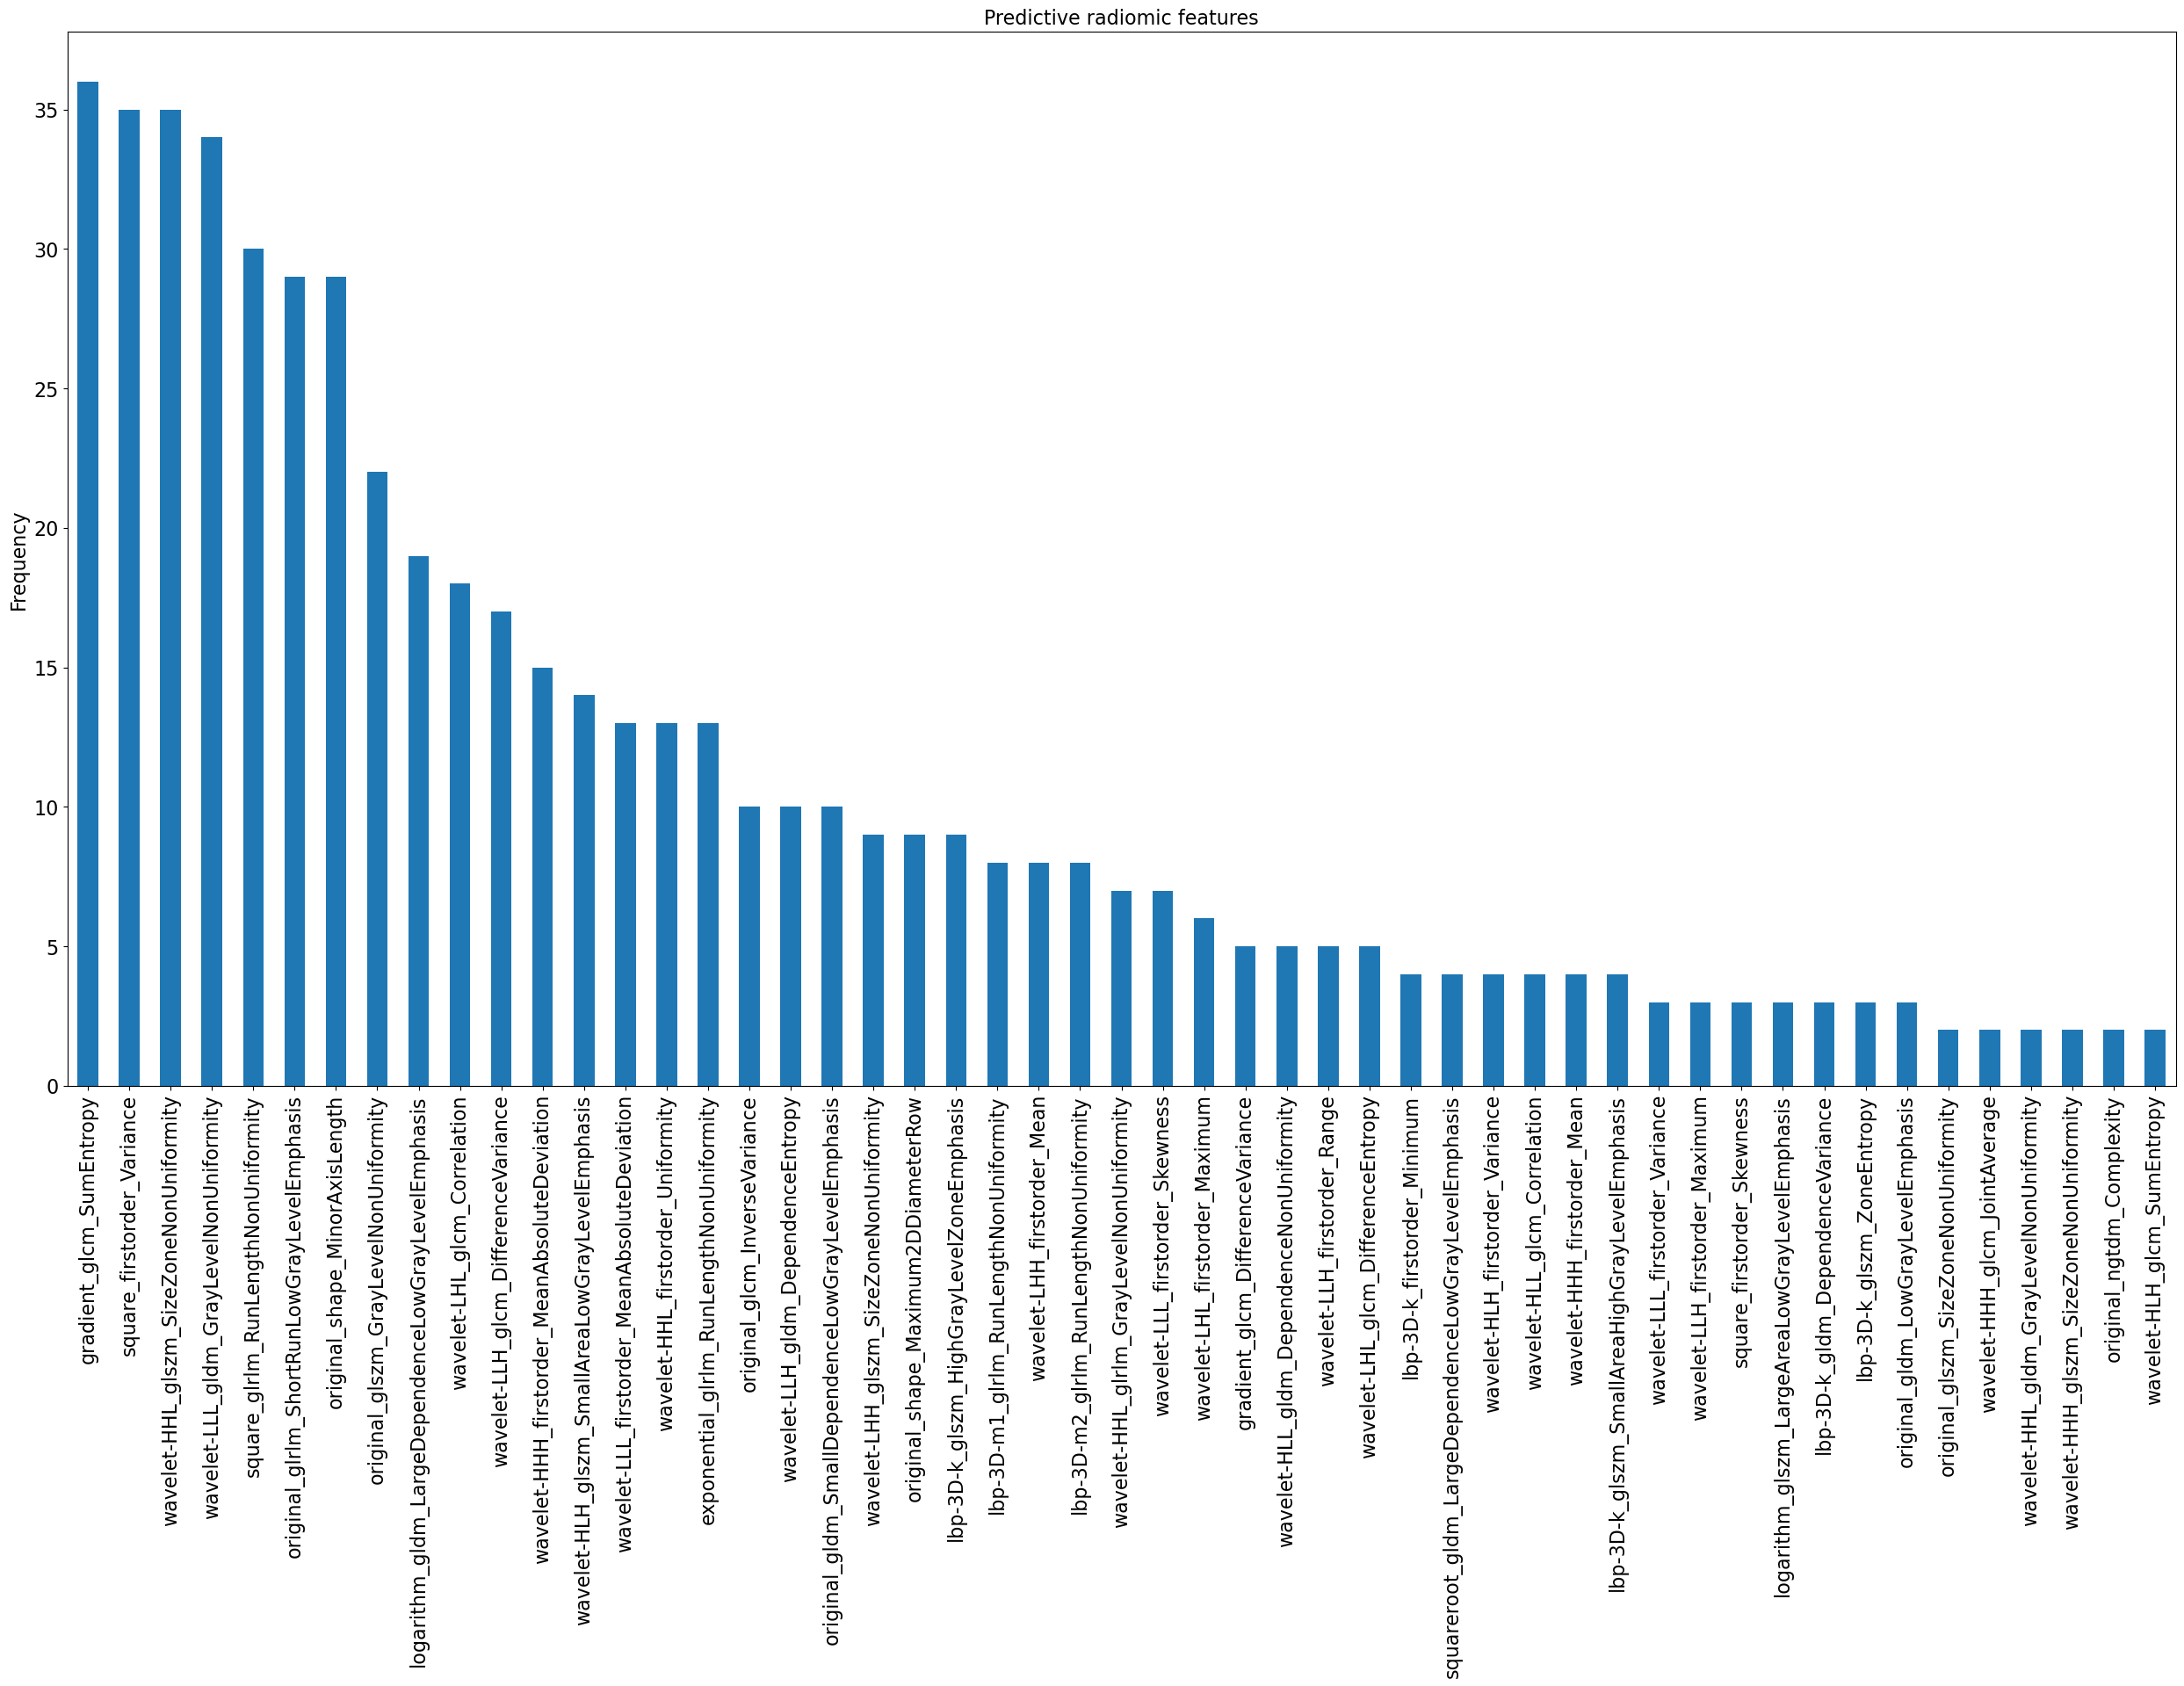

In [164]:
from collections import Counter

plt.rcParams["figure.figsize"] = (30,15)
fig, axes = plt.subplots(1,1,sharey=True)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.8)

R = [item for sublist in K_nz for item in sublist]
letter_counts = Counter(R)
lc = { x: count for x, count in letter_counts.items() if count > 1 }
df = pd.DataFrame.from_dict(lc, orient='index')
df.sort_values(0, ascending=False, inplace=True)
df.plot(ax=axes, y=0, kind='bar', legend=False, fontsize=16)
plt.title('Predictive radiomic features',fontsize=16)
plt.ylabel('Frequency',fontsize=16)

plt.style.use('default')

In [201]:
results_ls_aug_clt = np.zeros_like(per_change)
results_lgr_aug_clt = np.zeros_like(per_change)
results_lgrp_aug_clt = np.zeros_like(per_change)

In [239]:
retrain = 1
if retrain == 1:

  Js = []
  aug = True
  err_var = np.zeros_like(per_change)
  rerror = np.zeros_like(per_change)
  kappa = []
  K_nz = []
  E_nz = []
  c = 0

  K_all_c = np.append(K_all_c,['pre updrs']*5)
  for j in np.arange(len(subsc)):
      test_id = subsc[j]
      test_index = subsc == test_id
      train_index = subsc != test_id
      X_train = X_all_c[train_index,:,:]
      X_test = X_all_c[test_index,:,:]
      y_train = per_change[train_index]
      y_test = per_change[test_index]

      y_cat = y_train <= 0.3
      idy = np.where(y_cat==1)
      # Cross validation
                                            
      X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                  X_train,train_index,X_test,
                                                  test_index,pre_updrs_off,None,None,None,None,None,None,None,None,None,False,False,False)
      cvn = 5
      cv_scores = np.zeros((cvn,1))
      cv_lgr_scores = np.zeros((cvn,1))
      rs = 1
      rcfs = 1000
      (mu, sigma) = stats.norm.fit(y_train)
      kappa = stats.skew(y_train)
      print('Label distribution of:',mu,sigma,kappa)
      for jj in np.arange(2,cvn):
        # Resample to avoid stratification errors
        while np.sum(y_cat) < cvn:
          np.random.seed(rs)
          idyr = np.random.choice(np.asarray(idy).ravel())
          X0_ss0 = np.append(X0_ss0,X0_ss0[idyr,:].reshape(1,-1),axis=0)
          y_train = np.append(y_train,y_train[idyr])
          y_cat = y_train <= 0.3
          rs = rs+1
          print('Resampled to size',y_train.shape)
        if aug == True:
          # y_train_n = y_train+(1.96*sigma)*np.random.normal(0,1,1)
          z_train = (y_train-np.mean(y_train))/(np.std(y_train)/np.sqrt(len(y_train)))
          z_train_ns = z_train+1.96*np.std(z_train)*np.random.normal(0,1,1)
          y_train_n = z_train_ns*((np.std(y_train)/np.sqrt(len(y_train))))+np.mean(y_train)
          y_train = np.hstack((y_train,y_train_n))
          y_cat = y_train <= 0.3
          X0_ss0 = np.vstack((X0_ss0,X0_ss0))
      
      for jj in np.arange(2,cvn):
        skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
        skf_gen = skf_g.split(X0_ss0,y_cat)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None)
        with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
          # Feature selection
          warnings.filterwarnings("ignore", category=ConvergenceWarning)
          sel = skf.RFECV(lasso,step=rcfs,cv=skf_gen,n_jobs=1)
          # Stratifies classifiers automatically
          sel_lr = skf.RFECV(lgr,step=rcfs,cv=jj,n_jobs=1)
          X0_ss = sel.fit_transform(X0_ss0,y_train)
          X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
          est_ls = lasso.fit(X0_ss,y_train)
          est_lgr = lgr.fit(X0_ssl,y_cat)
          cv_scores[jj] = est_ls.score(X0_ss,y_train)
          cv_lgr_scores[jj] = est_lgr.score(X0_ssl,y_cat)
          print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
          
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
        best_cv = np.argmax(cv_scores)
        best_cv_lgr = np.argmax(cv_lgr_scores)

        # Break any ties
        if np.sum(cv_scores == best_cv) > 1:
          cv_scores_tb = np.zeros((np.sum(cv_scores == best_cv),1))
          cv_lgr_scores_tb = np.zeros((np.sum(cv_scores == best_cv_lgr),1))
          for jjj in (cv_scores == cv_scores[best_cv]):
            if jjj > 0:
              print('Breaking tie')
              skf_g = sms.StratifiedKFold(n_splits=np.arange(2,cvn)[jjj],shuffle=True,random_state=1)
              skf_gen = skf_g.split(X0_ss0,y_cat) 
              X0_ss = sel.fit_transform(X0_ss0,y_train)
              X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
              est_ls = lasso.fit(X0_ss,y_train)
              est_lgr = lgr.fit(X0_ssl,y_cat)
              lasso = slm.LassoLarsCV(max_iter=1000,cv=np.arange(2,cvn)[jjj],n_jobs=-1,normalize=False,eps=0.1)
              lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None)
              est_ls = lasso.fit(X0_ss,y_train)
              est_lgr = lgr.fit(X0_ssl,y_cat)
              cv_scores_tb[jjj] = est_ls.score(X0_ss,y_train)
              cv_lgr_scores_tb[jj] = est_lgr.score(sel_lr.fit_transform(X0_ss0,y_cat),y_cat)
          best_cv = np.argmax(cv_scores_tb)
          best_cv_lgr = np.argmax(cv_lgr_scores_tb)
        
        # Fit whole dataset with optimal cv
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=jj,class_weight=None)
        sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
        sel_lr = skf.RFECV(lgr,step=rcfs,cv=best_cv)
        X0_ss = sel.fit_transform(X0_ss0,y_train)
        X_test_ss = sel.transform(X_test_ss0)
        X0_ssl = sel_lr.fit_transform(X0_ss0,y_cat)
        X_test_ssl = sel_lr.transform(X_test_ss0)
        K_ss = sel.transform(K_all_c.reshape(1,-1))

      # LASSO
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        lgr = slm.LogisticRegressionCV(n_jobs=-1,cv=best_cv,class_weight=None)
        est_ls = lasso.fit(X0_ss,y_train)
        est_lgr = lgr.fit(X0_ssl,y_cat)
      results_lgr_aug_clt[c] = est_lgr.predict(X_test_ssl)
      results_lgrp_aug_clt[c] = est_lgr.predict_proba(X_test_ssl)[0][0]
      results_ls_aug_clt[c] = est_ls.predict(X_test_ss)
      print('Lasso predicts',str(np.round(results_ls_aug_clt[c],4)),'and logistic regression predicts',results_lgr_aug_clt[c],
                'for case with',str(np.round(np.repeat(per_change,r)[c],2)),'and selected CV',best_cv,'and',sum(y_cat),'minority cases')
      K_nz.append(np.squeeze(K_ss)[est_ls.coef_>0])
      E_nz.append(est_ls.coef_[est_ls.coef_>0])
      c=c+1

  # np.save('results_ls_aug_d.npy',results_ls_aug)
  # np.save('results_lgr_aug_d.npy',results_lgr_aug)
  # np.save('results_lgrp_aug_d.npy',results_lgrp_aug)

else:
  print('Loading')
  # results_ls_aug = np.load('results_ls_aug_d.npy')
  # results_lgr_aug = np.load('results_lgr_aug_d.npy')
  #results_lgrp_aug = np.load('results_lgr_aug_d.npy')

  


Label distribution of: 0.5669595264848581 0.20858808082526412 -0.24474920851943865
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.40032983] from dataset of size (304, 4385)
LassoCV score for 3 is [0.39001073] from dataset of size (304, 1385)
LassoCV score for 4 is [0.40032988] from dataset of size (304, 1385)
Lasso predicts 0.5983 and logistic regression predicts 0.0 for case with 0.72 and selected CV 4 and 103 minority cases
Label distribution of: 0.5738548357091768 0.20932917254901903 -0.3279210191356042
Resampled to size (37,)
Resampled to size (38,)
LassoCV score for 2 is [0.40032988] from dataset of size (304, 385)
LassoCV score for 3 is [0.39304126] from dataset of size (304, 2385)
LassoCV score for 4 is [0.40032988] from dataset of size (304, 3385)
Lasso predicts 0.3992 and logistic regression predicts 0.0 for case with 0.47 and selected CV 2 and 101 minority cases
Label distribution of: 0.5677185809199048 0.20908232478622193 -0.24926099868801613
Resam

In [240]:
len(y_cat)

304

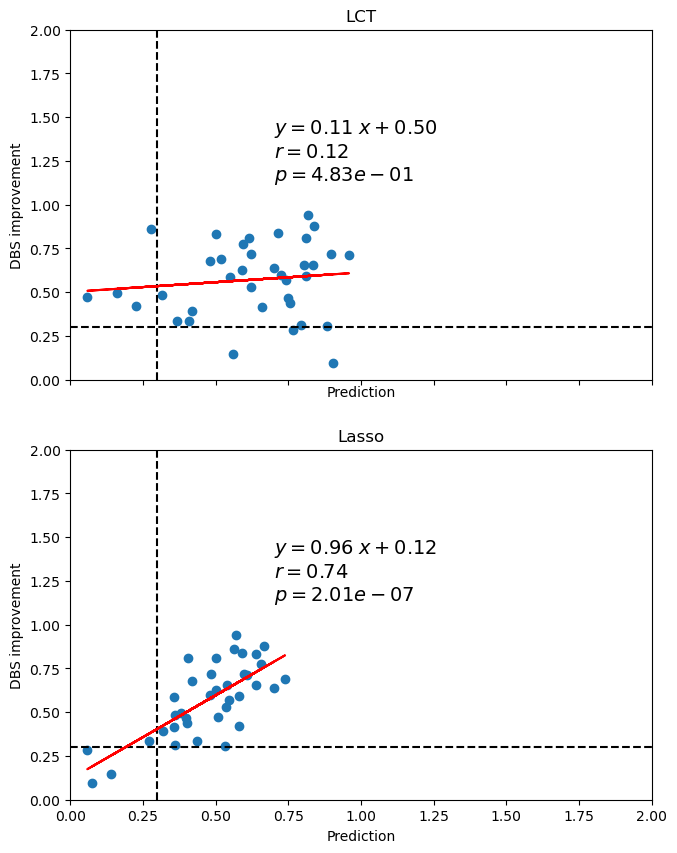

In [243]:
pre_imp = (np.asarray(pre_updrs_iii_off,dtype=float)-np.asarray(pre_updrs_iii_on,dtype=float))/np.asarray(pre_updrs_iii_off,dtype=float)
util.eval_prediction(np.vstack((pre_imp,
                               results_ls_aug_clt,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                ],(15,5))
plt.ylim([0,2])
plt.xlim([0,2])
plt.style.use('default')

In [244]:
y_predicted_aug_clt = 1-results_lgrp_aug_clt
fprac, tprac, _ = roc_curve(y_bin, y_predicted_aug_clt)
roc_auc_lr_aug_clt = auc(fprac, tprac)

acc_lgr_aug = util.classification_accuracy((results_lgr_aug_clt).astype(int),(per_change < 0.3).astype(int))
sns_lgr_aug = util.classification_sensitivity((results_lgr_aug_clt).astype(int),(per_change < 0.3).astype(int))
spf_lgr_aug = util.classification_specificity((results_lgr_aug_clt).astype(int),(per_change < 0.3).astype(int))
auc_lgr_aug_clt = roc_auc_lr_aug_clt

In [246]:
acc_lgr_aug

0.972972972972973